# <span style="color:MidnightBlue"> Part 11 | Cox Proportional Hazards Model in R with RStudio</span>.

https://www.youtube.com/watch?v=TrS2M5imOt8&list=PLqzoL9-eJTNDdnKvep_YHIwk2AMqHhuJ0&index=10


* Note : This note book is created with R in Jupyter Notebook instead of R studio
* Note : I summarized the note book while wathing the lecture 

In [1]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

__Load required packages__

https://cran.r-project.org/web/packages/survival/survival.pdf

In [2]:
library(survival)

## 1. Load Data set

__Usage__: stanford2 (See the document)

In [3]:
stanford2[1:10,]

,id,time,status,age,t5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139,139,86,1,12,1.26
159,159,10,1,13,1.49
181,181,60,0,13,NA
119,119,1116,0,14,0.54
74,74,2006,0,15,1.26
120,120,1107,0,18,0.25
99,99,1232,1,18,0.70
108,108,42,1,19,0.63
179,179,98,0,19,NA


* id: ID number
* time: survival or censoring time
* status: censoring status (1: Decresed, 0: Censored)
* age: in years
* t5: T5 mismatch score (Shows match or mismatch between Donor and Recipient , High number = Larger Degree of mismatch)

Since our data is not exactly same as the lecture, I will try to make the data form as much as the data in the lecture. 

## 2. Data preperation

__First rename the data set as Stan__

In [4]:
Stan <- stanford2
Stan[1:5,]
dim(Stan)

,id,time,status,age,t5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139,139,86,1,12,1.26
159,159,10,1,13,1.49
181,181,60,0,13,NA
119,119,1116,0,14,0.54
74,74,2006,0,15,1.26


[1] 184   5

__Delete the row if t5 is missing value__

https://www.programmingr.com/examples/remove-na-rows-in-r/

In [5]:
Stan <- na.omit(Stan) 
Stan[1:5,]
dim(Stan)

,id,time,status,age,t5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139,139,86,1,12,1.26
159,159,10,1,13,1.49
119,119,1116,0,14,0.54
74,74,2006,0,15,1.26
120,120,1107,0,18,0.25


[1] 157   5

__Add new coloumns: Over40 and MisMatchLevel__

__Over40__

In [6]:
Stan$Over40 <- ifelse(Stan$age > 40, 1, 0 )

In [9]:
Stan[1:5,]
Stan$Over40
table(Stan$Over40)

dim(Stan)

,id,time,status,age,t5,Over40
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139,139,86,1,12,1.26,0
159,159,10,1,13,1.49,0
119,119,1116,0,14,0.54,0
74,74,2006,0,15,1.26,0
120,120,1107,0,18,0.25,0


[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1


 0  1 
58 99 

[1] 157   6

__MisMatchLevel__

There is no clinical definiction of low, medium, high for mismatch. <br>
He used lower third, middle third and upper third for low, middle, high of  t5.
* 1 : Low degree of mismatch
* 2 : Medium level of mismatch
* 3 : High level of mismatch

In [10]:
bin <- quantile(Stan$t5,probs = c(1/3, 2/3 ,1))
bin

33.33333% 66.66667%      100% 
     0.83      1.33      3.05

We use quantile funtion to find lower thid, middle third, upper third.

In [11]:
bin2<-c(-1, bin)
bin2

33.33333% 66.66667%      100% 
    -1.00      0.83      1.33      3.05

In [13]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




The next line express if $t5 	\leq 0.83$ then 1, else if $ t5\leq1.33$ then 2, else 3

In [26]:
Stan<-Stan %>% mutate(MisMatchLevel 
                      = cut(Stan$t5, breaks=bin2, labels=FALSE))

In [27]:
table(Stan$MisMatchLevel)



 1  2  3 
53 53 51 

In [28]:
Stan[c("t5", "MisMatchLevel")][1:5,]

,t5,MisMatchLevel
,<dbl>,<int>
139,1.26,2
159,1.49,3
119,0.54,1
74,1.26,2
120,0.25,1


__Change "Over40" and "MisMatchLevel" factors__

In [30]:
Stan$Over40 <- as.factor(Stan$Over40)
Stan$MisMatchLevel <- as.factor(Stan$MisMatchLevel)

__Summary of the Data__

In [32]:
summary(Stan)

       id              time            status            age       
 Min.   :  1.00   Min.   :   0.5   Min.   :0.0000   Min.   :12.00  
 1st Qu.: 43.00   1st Qu.:  65.0   1st Qu.:0.0000   1st Qu.:36.00  
 Median : 83.00   Median : 468.0   Median :1.0000   Median :44.00  
 Mean   : 83.62   Mean   : 769.2   Mean   :0.6497   Mean   :41.73  
 3rd Qu.:123.00   3rd Qu.:1264.0   3rd Qu.:1.0000   3rd Qu.:49.00  
 Max.   :174.00   Max.   :3695.0   Max.   :1.0000   Max.   :64.00  
       t5        Over40 MisMatchLevel
 Min.   :0.000   0:58   1:53         
 1st Qu.:0.690   1:99   2:53         
 Median :1.040          3:51         
 Mean   :1.117                       
 3rd Qu.:1.460                       
 Max.   :3.050                       

__Raname the columns in the data__

In [37]:
names(Stan)

[1] "id"            "time"          "status"        "age"          
[5] "t5"            "Over40"        "MisMatchLevel"

In [41]:
colnames(Stan) <- c('ID', 'Time', 'Status', 'Age', 't5Score', 'Over40', 'MisMatchLevel')

In [42]:
names(Stan)

[1] "ID"            "Time"          "Status"        "Age"          
[5] "t5Score"       "Over40"        "MisMatchLevel"

__Attach the Data__

In [43]:
attach(Stan)

In this example, we attach the data but I prefer to designate the data frame name and its coloumn. <br>
Imagine if you are handling many data set at the same time, and they have same column names, it gives you confusion which is which without designaintg the data name 

### 3. Fit a KM Model

In [45]:
stan.KM <- survfit (Surv(Time, Status) ~ MisMatchLevel,  type="kaplan-meier")

In [46]:
summary(stan.KM)

Call: survfit(formula = Surv(Time, Status) ~ MisMatchLevel, type = "kaplan-meier")

                MisMatchLevel=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     53       2    0.962  0.0262        0.912        1.000
   12     51       1    0.943  0.0317        0.883        1.000
   25     50       1    0.925  0.0363        0.856        0.998
   26     49       1    0.906  0.0402        0.830        0.988
   31     48       1    0.887  0.0435        0.805        0.976
   36     47       1    0.868  0.0465        0.781        0.964
   42     46       1    0.849  0.0492        0.758        0.951
   44     45       1    0.830  0.0516        0.735        0.938
   45     44       1    0.811  0.0537        0.713        0.924
   46     43       1    0.792  0.0557        0.690        0.910
   47     42       1    0.774  0.0575        0.669        0.895
   48     41       1    0.755  0.0591        0.647        0.880
   50     40       1    0.736  0.0606        0.626 

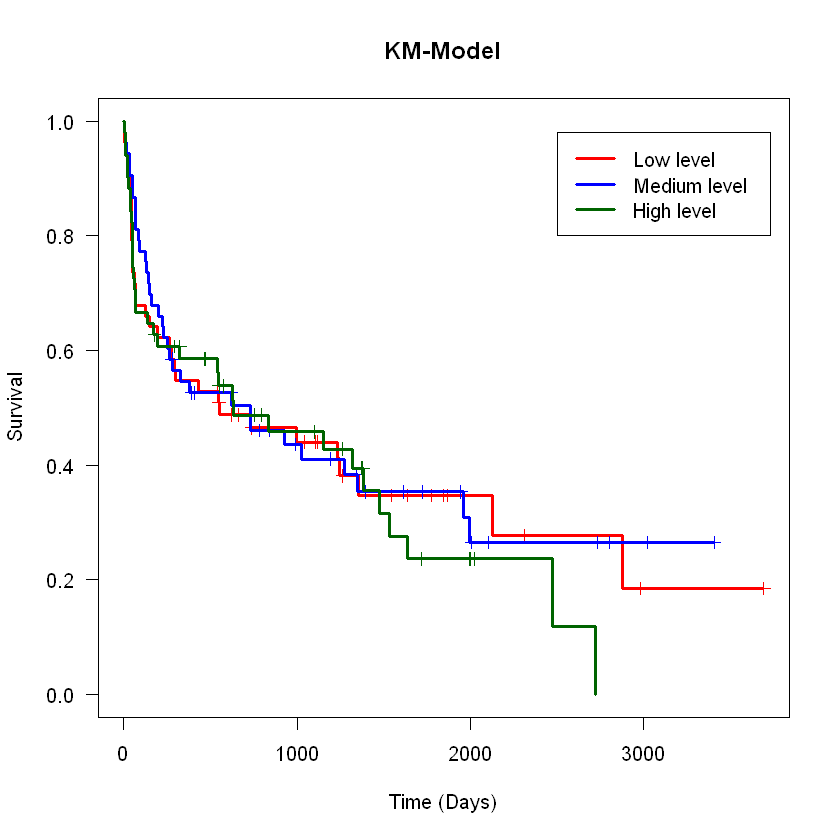

In [52]:
plot(stan.KM, conf.int=F, xlab="Time (Days)", ylab="Survival", main="KM-Model", 
     col=c("red", "blue", "darkgreen"), las=1, lwd=3, mark.time=TRUE)

# add the legend: legend(x Coordinate  , y Coordinate )
# lty=1, solid line
# lwd=2, line width
# cex : size of legend box
legend(2500, 0.98, legend=c("Low level", "Medium level", "High level"), lty=1, lwd=3, 
      col=c("red", "blue", "darkgreen"), bty="", cex=1)

It seems there is no significant difference between MisMatchLevel.

### 4. Cox Proportional Hazards Model

__Lets fit the Cox-PH model, and use both Over 40 and MMlevel__

In [53]:
cox.mod <- coxph(Surv(Time, Status) ~ Over40 + MisMatchLevel)

In [54]:
summary(cox.mod)

Call:
coxph(formula = Surv(Time, Status) ~ Over40 + MisMatchLevel)

  n= 157, number of events= 102 

                   coef exp(coef) se(coef)      z Pr(>|z|)  
Over401         0.52547   1.69126  0.21855  2.404   0.0162 *
MisMatchLevel2 -0.06639   0.93576  0.24297 -0.273   0.7846  
MisMatchLevel3  0.10315   1.10866  0.24353  0.424   0.6719  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
Over401           1.6913     0.5913    1.1020     2.596
MisMatchLevel2    0.9358     1.0686    0.5812     1.507
MisMatchLevel3    1.1087     0.9020    0.6879     1.787

Concordance= 0.563  (se = 0.031 )
Likelihood ratio test= 6.58  on 3 df,   p=0.09
Wald test            = 6.21  on 3 df,   p=0.1
Score (logrank) test = 6.34  on 3 df,   p=0.1


We see the result. 
* n=157: the number of observation, number of events = 102
* coef : coefficient, Note: There is no coefficient for "intercept" since for Cox model, baseline hazard is unspecified. Note that we cannot estimate survival function in Cox model. But we can estimate hazard ratio.

* exp(coef): exponenciated coeffiecient which give us the hazard ratio. In this example, exp(coef)=1.69126 for Over401. Which means "at a given instant in time, someone who is over 40 is 1.68 times as likely to die as someone who is under 40 adjusting for mismatch level.

* exp(-coef): In this example, exp(-coef)=0.5914 for Over401. Which means "at a given instant in time, someone who is under 40 is 0.59 times as likely to die as someone who is over 40 adjusting for mismatch level.

* The last part is Hypothesis H<sub>0</sub>: $\beta$<sub>1</sub>$=$$\beta$<sub>2</sub>$=$...$=$$\beta$<sub>k</sub>$=0$ and for  H<sub>a</sub>,  at least one $\beta$<sub>i</sub> is not zero.

* Concordance, we have 0.563 ... random guess is 0.5...

* For test part, p value is all over then $\alpha$ level 5%, we fail to reject the Null hypothesis

__Comparing nested models using the Likelihood ratio test(LRT) (Can we drop MMlevel?)__

In [57]:
cox.mod <- coxph(Surv(Time, Status) ~ Over40 + MisMatchLevel)

In [58]:
cox.mod2 <- coxph(Surv(Time, Status) ~ Over40)

__Do LRT to compare two models__

In [59]:
anova(cox.mod2, cox.mod, test="LRT")

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-448.0490,NA,NA,NA
2,-447.8047,0.4886271,2,0.783242


P-value is very large, thus we can choose cox.mod2. We can drop MisMathchLevel without lose of predicted power. 

## 5. Now we add numerical X variable into the model

In [61]:
cox.num <- coxph(Surv(Time, Status) ~ Age + t5Score)

In [62]:
summary(cox.num)

Call:
coxph(formula = Surv(Time, Status) ~ Age + t5Score)

  n= 157, number of events= 102 

           coef exp(coef) se(coef)     z Pr(>|z|)   
Age     0.02961   1.03006  0.01136 2.608  0.00911 **
t5Score 0.17041   1.18579  0.18326 0.930  0.35243   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
Age         1.030     0.9708     1.007     1.053
t5Score     1.186     0.8433     0.828     1.698

Concordance= 0.59  (se = 0.034 )
Likelihood ratio test= 8.47  on 2 df,   p=0.01
Wald test            = 7.81  on 2 df,   p=0.02
Score (logrank) test = 7.87  on 2 df,   p=0.02


* __exp(coef) of Age__ is 1.030 : At a given instant in time, the probability of dying for someone who is 1 year older is 3% higher than someone who is 1 year younger adjusting for t5 score

# <span style="color:MidnightBlue"> Survival Analysis Part 12 | Checking Cox PH Model Assumptions in R with RStudio </span>.

https://www.youtube.com/watch?v=M1QQ8QQn8Zs&list=PLqzoL9-eJTNDdnKvep_YHIwk2AMqHhuJ0&index=11

Recall the model we fit in the previous part

In [65]:
cox.num <- coxph(Surv(Time, Status) ~ Age + t5Score)

We will review

* how to check linearity
* how to check the proportional hazard's assumptions

### 1. Checking linearity for the model that used numerical X variables

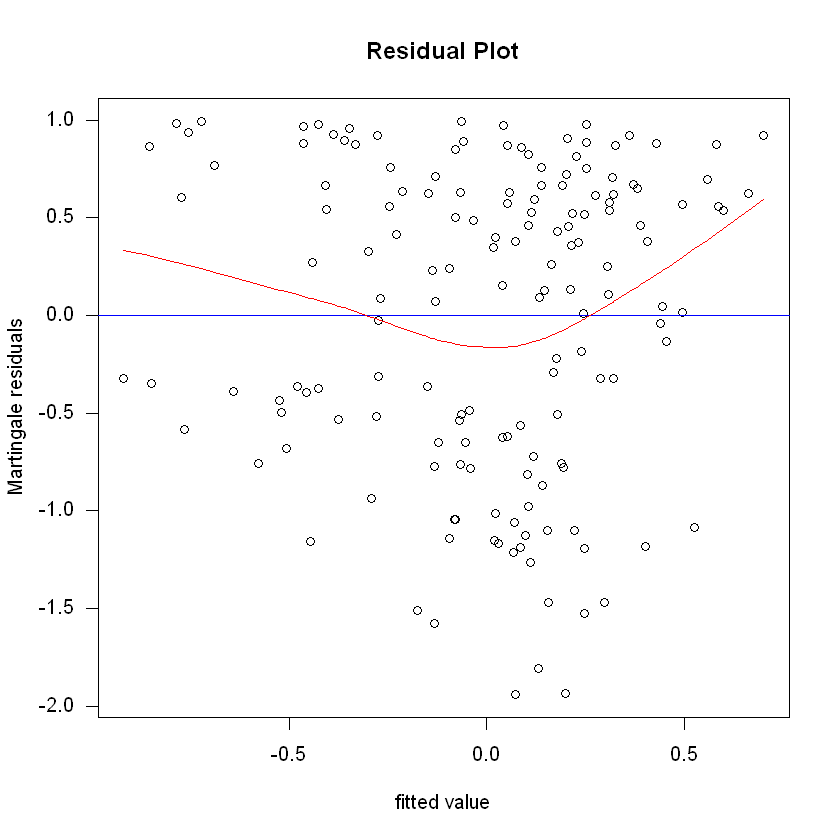

In [71]:
# using Martingale residuals

plot(predict(cox.num), residuals(cox.num, type="martingale"),
     xlab="fitted value", ylab="Martingale residuals",
     main="Residual Plot", las=1)

# add a line ax residual=0 
abline(h=0, col="blue")

# fit a smoother thru the points
lines(smooth.spline(predict(cox.num), residuals(cox.num, type="martingale")), col="red")

Seems there is a little bit non-linearity

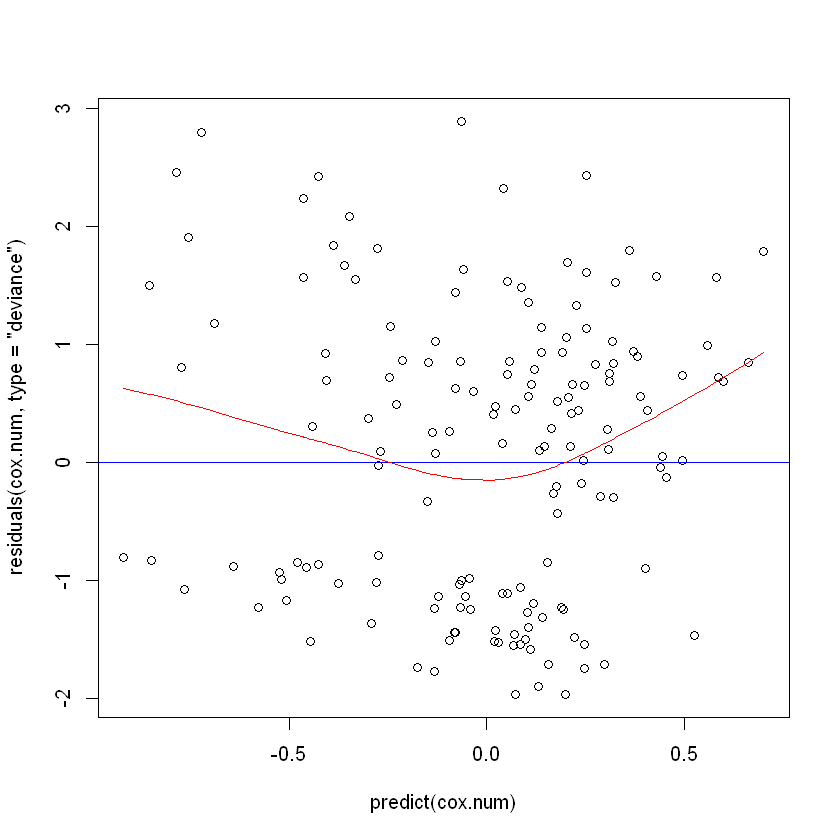

In [75]:
# Checking linearity using Deviance residuals
plot(predict(cox.num), residuals(cox.num, type="deviance"))
abline(h=0, col="blue")
lines(smooth.spline(predict(cox.num), residuals(cox.num, type="deviance")), col="red")

The deviance residual has also same pattern.

__Solution__ to solve non-linearity is same  as linear regression model such as categorizing including polymonial terms, transforming it.  

## 2. Checking proportional hazards assumption

Test for proportional hazards using Schoenfeld test for PH
* H<sub>0</sub>: Hazards are proportional.
* H<sub>a</sub>: Hazards are not proportionl.

This test will return test for each X, and for overall model

In [78]:
cox.zph(cox.num)

        chisq df    p
Age      0.83  1 0.36
t5Score  2.06  1 0.15
GLOBAL   2.77  2 0.25

For all p-value is greater than 0.05, thus we fail to reject the Null hypothesis.

We can see a plot of these as well (one plot for each parameter). These are plots of "changes in b over time", if we let "b, coefficient" vary over time, this means that there is not PH. The effect is not constact over time. 

In [87]:
# Split screen in 2 by 1
# par(mfrow = c(2,1))

# plot(cox.zph(cox.num))

In [86]:
par(mfrow = c(1,1))

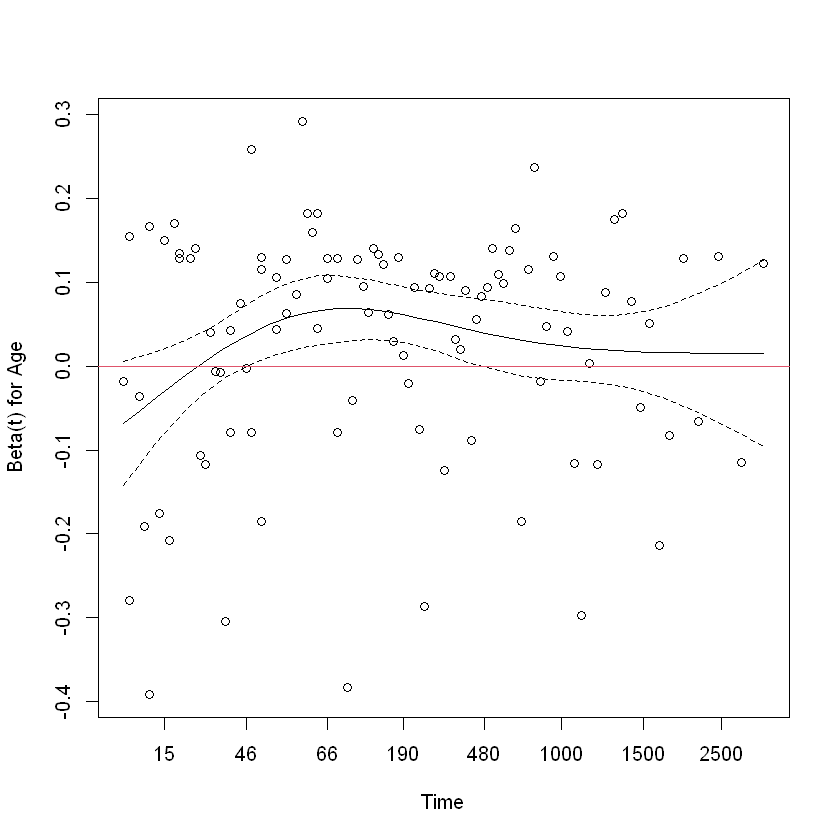

In [91]:
# age
plot(cox.zph(cox.num)[1])
abline(h=0, col=2)

Coefficient does change over time.

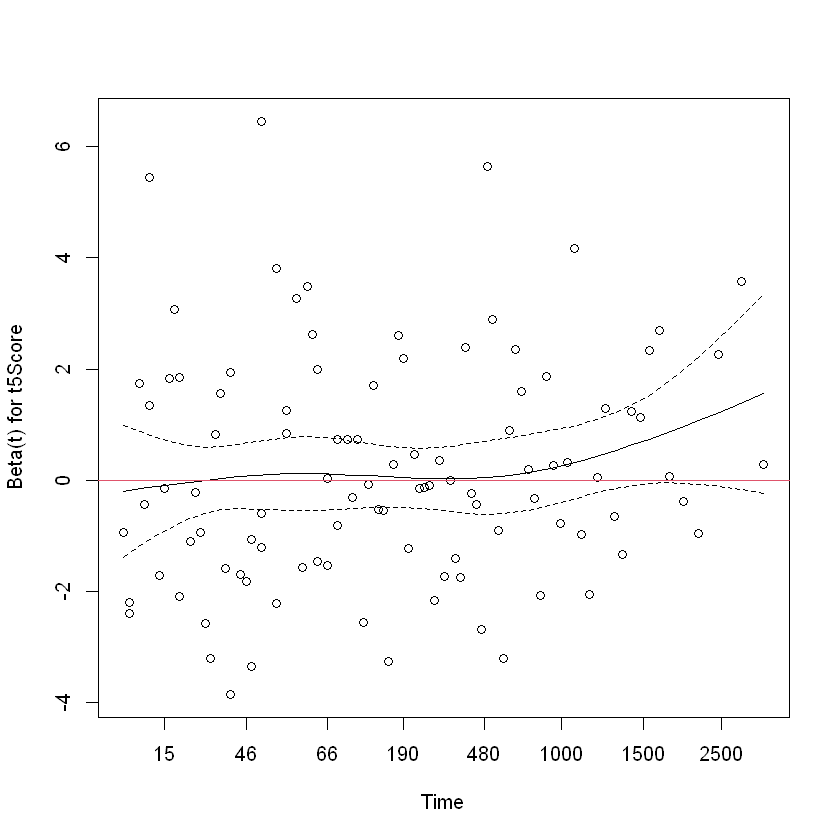

In [92]:
# t5
plot(cox.zph(cox.num)[2])
abline(h=0, col=2)

Coefficient almost does not change over time.